#### Copyright 2018 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Classification of Various Metal Oxide Materials with Model Fine-Tuning



## Feature Extraction Using a Pretrained Model

One thing that is commonly done in computer vision is to take a model trained on a very large dataset, run it on your own, smaller dataset, and extract the intermediate representations (features) that the model generates. These representations are frequently informative for your own computer vision task, even though the task may be quite different from the problem that the original model was trained on. This versatility and repurposability of convnets is one of the most interesting aspects of deep learning.

In our case, we will use the [Inception V3 model](https://arxiv.org/abs/1512.00567) developed at Google, and pre-trained on [ImageNet](http://image-net.org/), a large dataset of web images (1.4M images and 1000 classes). This is a powerful model; let's see what the features that it has learned can do for our cat vs. dog problem.

First, we need to pick which intermediate layer of Inception V3 we will use for feature extraction. A common practice is to use the output of the very last layer before the `Flatten` operation, the so-called "bottleneck layer." The reasoning here is that the following fully connected layers will be too specialized for the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate an Inception V3 model preloaded with weights trained on ImageNet:


In [1]:
 #mount google drive with images
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sn

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

%tensorflow_version 2.x
import tensorflow as tf
print('TensorFlow version is {}'.format(tf.__version__))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TensorFlow version is 2.2.0


In [3]:
#check that you have the right GPUs and RAM
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Found GPU at: /device:GPU:0
Fri Jun  5 05:58:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    34W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                

Now let's download the weights:

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-06-05 05:58:58--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 2607:f8b0:4001:c1d::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   147MB/s    in 0.6s    

2020-06-05 05:58:59 (147 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top—ideal for feature extraction.

Let's make the model non-trainable, since we will only use it for feature extraction; we won't update the weights of the pretrained model during training.

In [0]:
for layer in pre_trained_model.layers:
  layer.trainable = False

The layer we will use for feature extraction in Inception v3 is called `mixed7`. It is not the bottleneck of the network, but we are using it to keep a sufficiently large feature map (7x7 in this case). (Using the bottleneck layer would have resulting in a 3x3 feature map, which is a bit small.) Let's get the output from `mixed7`:

In [7]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


Now let's stick a fully connected classifier on top of `last_output`:

In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final softmax layer for classification
x = layers.Dense(10, activation='softmax')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.CategoricalCrossentropy (),
#              metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

Find all the train and validation file directories, and count the number of images in each.

In [0]:
#add data locations
train_dir = './drive/My Drive/SupportClassification/ten_supports/train'
validation_dir = './drive/My Drive/SupportClassification/ten_supports/validation'

train_Al2O3_dir = os.path.join(train_dir, 'Al2O3')
train_CeO2_dir = os.path.join(train_dir, 'CeO2')
train_Co2O3_dir = os.path.join(train_dir, 'Co2O3')
train_MgO_dir = os.path.join(train_dir, 'MgO')
train_NPs_dir = os.path.join(train_dir, 'NPs')
train_POF_dir = os.path.join(train_dir, 'POF')
train_SiO2a_dir = os.path.join(train_dir, 'SiO2a')
train_SiO2Al2O3_30pc_dir = os.path.join(train_dir, 'SiO2Al2O3_30pc')
train_SiO2NBs_dir = os.path.join(train_dir, 'SiO2NBs')
train_TiO2_dir = os.path.join(train_dir, 'TiO2')

validation_Al2O3_dir = os.path.join(validation_dir, 'Al2O3')
validation_CeO2_dir = os.path.join(validation_dir, 'CeO2')
validation_Co2O3_dir = os.path.join(validation_dir, 'Co2O3')
validation_MgO_dir = os.path.join(validation_dir, 'MgO')
validation_NPs_dir = os.path.join(validation_dir, 'NPs')
validation_POF_dir = os.path.join(validation_dir, 'POF')
validation_SiO2a_dir = os.path.join(validation_dir, 'SiO2a')
validation_SiO2Al2O3_30pc_dir = os.path.join(validation_dir, 'SiO2Al2O3_30pc')
validation_SiO2NBs_dir = os.path.join(validation_dir, 'SiO2NBs')
validation_TiO2_dir = os.path.join(validation_dir, 'TiO2')

num_Al2O3_tr = len(os.listdir(train_Al2O3_dir))
num_CeO2_tr = len(os.listdir(train_CeO2_dir))
num_Co2O3_tr = len(os.listdir(train_Co2O3_dir))
num_MgO_tr = len(os.listdir(train_MgO_dir))
num_NPs_tr = len(os.listdir(train_NPs_dir))
num_POF_tr = len(os.listdir(train_POF_dir))
num_SiO2a_tr = len(os.listdir(train_SiO2a_dir))
num_SiO2Al2O3_30pc_tr = len(os.listdir(train_SiO2Al2O3_30pc_dir))
num_SiO2NBs_tr = len(os.listdir(train_SiO2NBs_dir))
num_TiO2_tr = len(os.listdir(train_TiO2_dir))

num_Al2O3_val = len(os.listdir(validation_Al2O3_dir))
num_CeO2_val = len(os.listdir(validation_CeO2_dir))
num_Co2O3_val = len(os.listdir(validation_Co2O3_dir))
num_MgO_val = len(os.listdir(validation_MgO_dir))
num_NPs_val = len(os.listdir(validation_NPs_dir))
num_POF_val = len(os.listdir(validation_POF_dir))
num_SiO2a_val = len(os.listdir(validation_SiO2a_dir))
num_SiO2Al2O3_30pc_val = len(os.listdir(validation_SiO2Al2O3_30pc_dir))
num_SiO2NBs_val = len(os.listdir(validation_SiO2NBs_dir))
num_TiO2_val = len(os.listdir(validation_TiO2_dir))

total_train = num_Al2O3_tr + num_CeO2_tr + num_Co2O3_tr + num_MgO_tr + num_NPs_tr + num_POF_tr + num_SiO2a_tr + num_SiO2Al2O3_30pc_tr + num_SiO2NBs_tr + num_TiO2_tr
total_val = num_Al2O3_val + num_CeO2_val + num_Co2O3_val + num_MgO_val + num_NPs_val + num_POF_val + num_SiO2a_val + num_SiO2Al2O3_30pc_val + num_SiO2NBs_val + num_TiO2_val

#numbers used for class balancing! cb = class balance, these are the ratios to emphasize in our weighted loss function
Al2O3_cb = ((num_Al2O3_tr / num_TiO2_tr)**-1)
CeO2_cb = ((num_CeO2_tr / num_TiO2_tr)**-1)
Co2O3_cb = ((num_Co2O3_tr / num_TiO2_tr)**-1)
MgO_cb = ((num_MgO_tr / num_TiO2_tr)**-1)
NPs_cb = ((num_NPs_tr / num_TiO2_tr)**-1)
POF_cb = ((num_POF_tr / num_TiO2_tr)**-1)
SiO2a_cb = ((num_SiO2a_tr / num_TiO2_tr)**-1)
SiO2Al2O3_30pc_cb = ((num_SiO2Al2O3_30pc_tr / num_TiO2_tr)**-1)
SiO2NBs_cb = ((num_SiO2NBs_tr / num_TiO2_tr)**-1)
TiO2_cb = ((num_TiO2_tr / num_TiO2_tr)**-1)

Set up the generators to generate sets of training and test data.

In [13]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data without augmentation

validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

batch_size = 256
epochs = 100
IMG_HEIGHT = 150
IMG_WIDTH = 150

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              shuffle = False)

Found 13122 images belonging to 10 classes.
Found 6336 images belonging to 10 classes.


Set up callbacks for the first round of model optimization

In [0]:
#Lets define our callback function, starting with our save directory
checkpoint_path = "drive/My Drive/SupportClassification/ten_supports/ten_class_weights/ten_class_weights_p1.hdf5.ckpt"

checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only = True)

Finally, let's train the model using the features we extracted. We'll be training on all the images available (> 13000) and testing on all test images (>6000) each epoch for validation accuracy.

In [15]:
#can take ~100 min for first epoch!!!
#https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403
#I believe this code should run through entire training dataset in each epoch
#And for vlaidation, check on entire validation set
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    class_weight = {0: Al2O3_cb, 1:CeO2_cb, 2:Co2O3_cb, 3:MgO_cb, 4:NPs_cb, 5:POF_cb, 6:SiO2Al2O3_30pc_cb, 7:SiO2NBs_cb, 8:SiO2a_cb, 9:TiO2_cb}, #this last line makes the loss function sensitive to different misclassifications differently
    callbacks=[cp_callback] 
)#note that the acc and val_acc are not class balanced; we will calculate a class balanced accuracy below

Epoch 1/100
51/51 [==============================] - ETA: 0s - loss: 4.9255 - acc: 0.5762 
Epoch 00001: val_loss improved from inf to 0.85171, saving model to drive/My Drive/SupportClassification/ten_supports/ten_class_weights/ten_class_weights_p1.hdf5.ckpt
51/51 [==============================] - 3890s 76s/step - loss: 4.9255 - acc: 0.5762 - val_loss: 0.8517 - val_acc: 0.7223
Epoch 2/100
51/51 [==============================] - ETA: 0s - loss: 3.0435 - acc: 0.6969
Epoch 00002: val_loss did not improve from 0.85171
51/51 [==============================] - 164s 3s/step - loss: 3.0435 - acc: 0.6969 - val_loss: 1.1060 - val_acc: 0.6237
Epoch 3/100
51/51 [==============================] - ETA: 0s - loss: 2.3789 - acc: 0.7423
Epoch 00003: val_loss improved from 0.85171 to 0.84666, saving model to drive/My Drive/SupportClassification/ten_supports/ten_class_weights/ten_class_weights_p1.hdf5.ckpt
51/51 [==============================] - 164s 3s/step - loss: 2.3789 - acc: 0.7423 - val_loss: 0.8

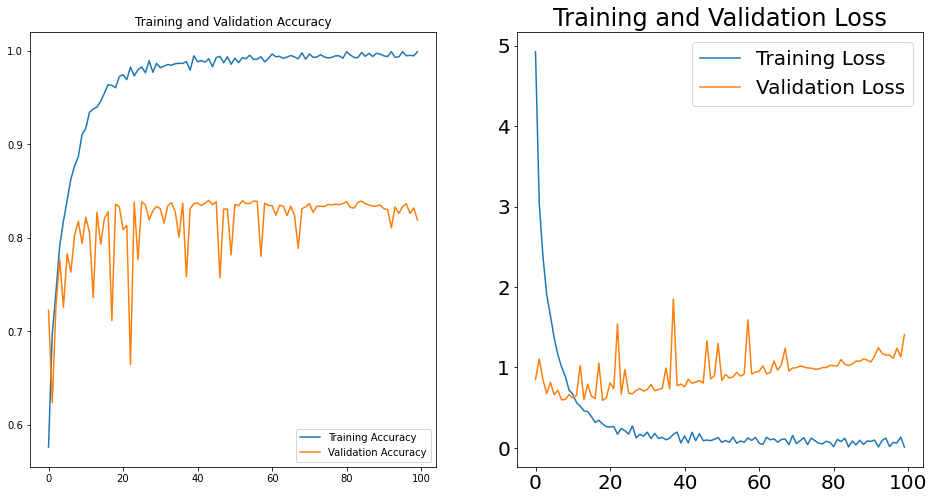

In [16]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.rcParams.update({'font.size': 20})

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.rcParams.update({'font.size': 20})
plt.show()



Found 6336 images belonging to 10 classes.
Instructions for updating:
Please use Model.predict, which supports generators.

 Confusion Matrix 
[[ 648   16    0   17    6   23    8    3   34  202]
 [  29  463    1    5    3   12    1    3   18  104]
 [   3    4   21   12    0    0    0    1    1   20]
 [  32    8    2   96    5    7    1    6    4  100]
 [   4    3    0    1 1284    0    0    1    1   11]
 [  33    5    1    4    1  410    3    1   25   22]
 [  15    2    0    0    0   15   43    0    1    1]
 [   0    2    0    1    3    1    0  327    4   19]
 [  64    8    0    7   10   28    3    0  138   55]
 [  31   11    1    9    0    1    0    0   12 1795]] 

Classification Report
                        precision    recall  f1-score   support

           Al$_2$O$_3$       0.75      0.68      0.71       957
               CeO$_2$       0.89      0.72      0.80       639
           Co$_2$O$_3$       0.81      0.34      0.48        62
                   MgO       0.63      0.37  

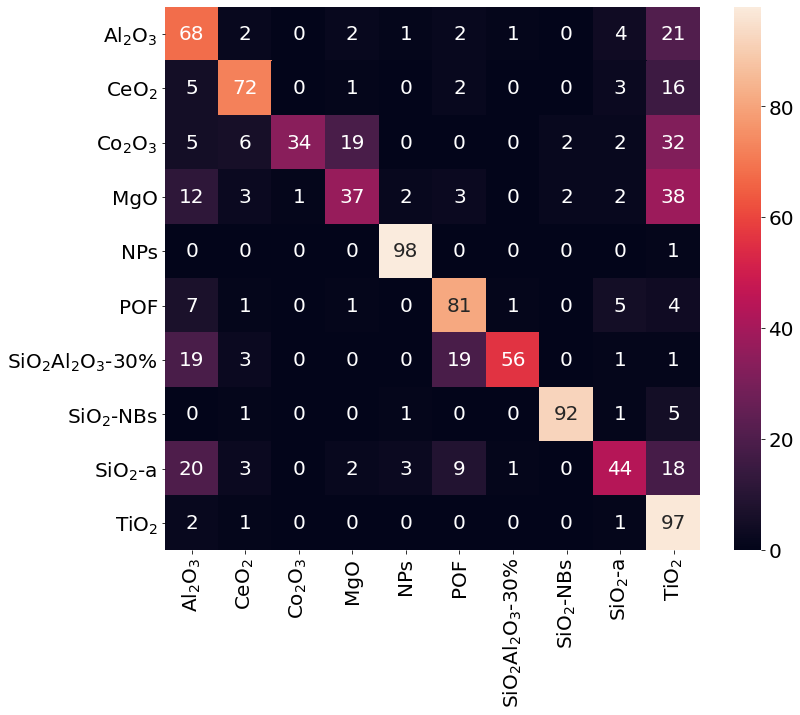

In [17]:
#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

#pull new validation data, that is unshuffled, for confusion matrix
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              shuffle = False)

target_names = ['Al$_2$O$_3$', 'CeO$_2$', 'Co$_2$O$_3$', 'MgO', 'NPs', 'POF', 'SiO$_2$Al$_2$O$_3$-30%', 'SiO$_2$-NBs', 'SiO$_2$-a', 'TiO$_2$']

Y_pred = model.predict_generator(val_data_gen, 6336 // batch_size+1) #distribution between classes
y_pred = np.argmax(Y_pred, axis=1) #most likely class
print('\n', 'Confusion Matrix ')
conf_mat = confusion_matrix(val_data_gen.classes, y_pred)
print(conf_mat, '\n')
print('Classification Report')
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))


#beautiful confusion matrix as percentages with sklearn
row_sums = np.sum(conf_mat, axis = 1, keepdims = True)
conf_mat = np.round(conf_mat / row_sums * 100, 0)

df_cm = pd.DataFrame(conf_mat, index = [i for i in target_names],
                  columns = [i for i in target_names])
fig = plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True)
plt.rcParams.update({'font.size': 24})

final_acc = 0
for i in range(len(conf_mat)):
  final_acc += conf_mat[i,i]
final_acc /= 10
print('Class-balanced final accuracy is {} percent'.format(final_acc))

## Further Improving Accuracy with Fine-Tuning

In our feature-extraction experiment, we only tried adding two classification layers on top of an Inception V3 layer. The weights of the pretrained network were not updated during training. One way to increase performance even further is to "fine-tune" the weights of the top layers of the pretrained model alongside the training of the top-level classifier. A couple of important notes on fine-tuning:

- **Fine-tuning should only be attempted *after* you have trained the top-level classifier with the pretrained model set to non-trainable**. If you add a randomly initialized classifier on top of a pretrained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier), and your pretrained model will just forget everything it has learned.
- Additionally, we **fine-tune only the *top layers* of the pre-trained model** rather than all layers of the pretrained model because, in a convnet, the higher up a layer is, the more specialized it is. The first few layers in a convnet learn very simple and generic features, which generalize to almost all types of images. But as you go higher up, the features are increasingly specific to the dataset that the model is trained on. The goal of fine-tuning is to adapt these specialized features to work with the new dataset.

All we need to do to implement fine-tuning is to set the top layers of Inception V3 to be trainable, recompile the model (necessary for these changes to take effect), and resume training. Let's unfreeze all layers belonging to the `mixed7` module—i.e., all layers found after `mixed6`—and recompile the model:

In [0]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

Set up callbacks for round two model optimization

In [0]:
#Lets define our callback function, starting with our save directory
checkpoint_path = "drive/My Drive/SupportClassification/ten_supports/ten_class_weights/ten_class_weights_p2.hdf5.ckpt"

checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only = True)

Now let's retrain the model. We'll train on all 2000 images available, for 50 epochs, and validate on all 1,000 validation images. (This may take 15-20 minutes to run.)

In [20]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    class_weight = {0: Al2O3_cb, 1:CeO2_cb, 2:Co2O3_cb, 3:MgO_cb, 4:NPs_cb, 5:POF_cb, 6:SiO2Al2O3_30pc_cb, 7:SiO2NBs_cb, 8:SiO2a_cb, 9:TiO2_cb},
    callbacks=[cp_callback] 
)

Epoch 1/100
51/51 [==============================] - ETA: 0s - loss: 1.6838 - acc: 0.7982
Epoch 00001: val_loss improved from inf to 0.98040, saving model to drive/My Drive/SupportClassification/ten_supports/ten_class_weights/ten_class_weights_p2.hdf5.ckpt
51/51 [==============================] - 162s 3s/step - loss: 1.6838 - acc: 0.7982 - val_loss: 0.9804 - val_acc: 0.8185
Epoch 2/100
51/51 [==============================] - ETA: 0s - loss: 0.4672 - acc: 0.9234
Epoch 00002: val_loss improved from 0.98040 to 0.95549, saving model to drive/My Drive/SupportClassification/ten_supports/ten_class_weights/ten_class_weights_p2.hdf5.ckpt
51/51 [==============================] - 161s 3s/step - loss: 0.4672 - acc: 0.9234 - val_loss: 0.9555 - val_acc: 0.8031
Epoch 3/100
51/51 [==============================] - ETA: 0s - loss: 0.3144 - acc: 0.9535
Epoch 00003: val_loss did not improve from 0.95549
51/51 [==============================] - 160s 3s/step - loss: 0.3144 - acc: 0.9535 - val_loss: 0.9610

We are seeing a nice improvement, with the validation loss going from ~1.7 down to ~1.2, and accuracy going from 88% to 92%. That's a 4.5% relative improvement in accuracy.

Let's plot the training and validation loss and accuracy to show it conclusively:

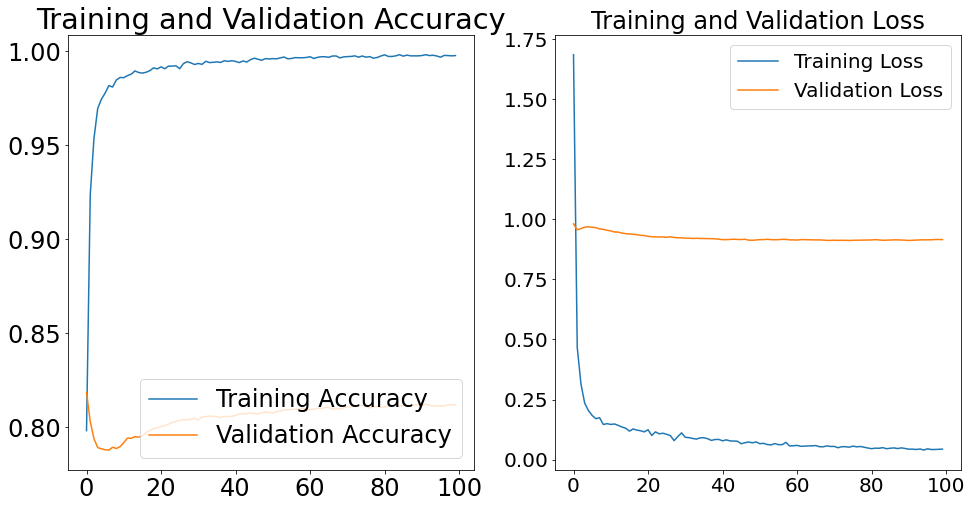

In [21]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.rcParams.update({'font.size': 20})

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.rcParams.update({'font.size': 20})
plt.show()



Found 6336 images belonging to 10 classes.

 Confusion Matrix 
[[ 686   46    0   22    7   28    6    3   40  119]
 [  45  502    2    9    1   12    2    7   11   48]
 [   2    9   24    8    0    0    0    6    1   12]
 [  36   21    5  102   10   15    0    8    3   61]
 [   6    7    1    1 1279    4    0    2    1    4]
 [  33   13    1    4    1  418    6    0   15   14]
 [  19    7    0    1    0    9   38    0    3    0]
 [   0    4    1    1    4    1    0  330    4   12]
 [  79   19    1   14   11   36    2    2  121   28]
 [  76   39    7   34    1    8    0    4   21 1670]] 

Classification Report
                        precision    recall  f1-score   support

           Al$_2$O$_3$       0.70      0.72      0.71       957
               CeO$_2$       0.75      0.79      0.77       639
           Co$_2$O$_3$       0.57      0.39      0.46        62
                   MgO       0.52      0.39      0.45       261
                   NPs       0.97      0.98      0.98      13

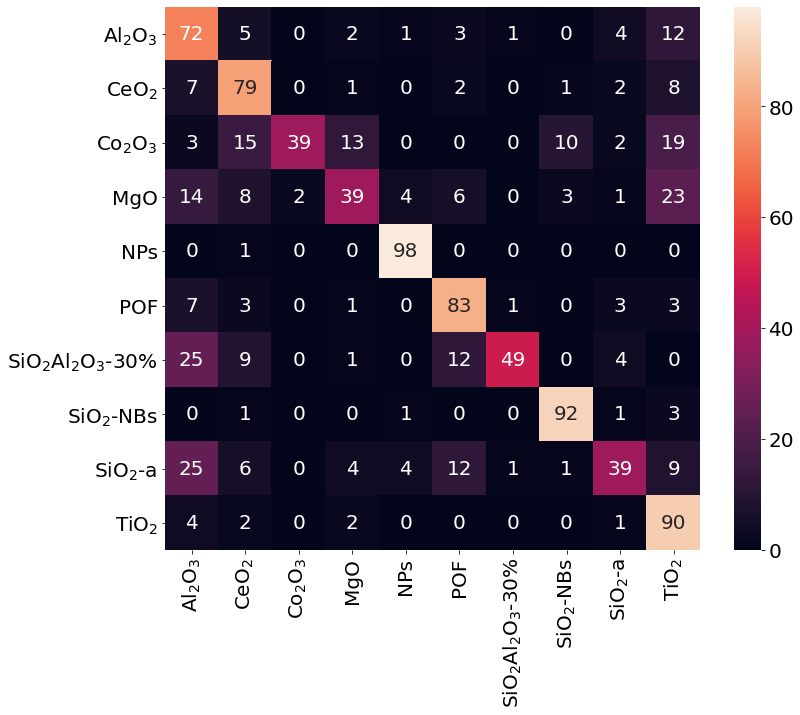

In [22]:
#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

#pull new validation data, that is unshuffled, for confusion matrix
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              shuffle = False)

target_names = ['Al$_2$O$_3$', 'CeO$_2$', 'Co$_2$O$_3$', 'MgO', 'NPs', 'POF', 'SiO$_2$Al$_2$O$_3$-30%', 'SiO$_2$-NBs', 'SiO$_2$-a', 'TiO$_2$']

Y_pred = model.predict_generator(val_data_gen, 6336 // batch_size+1) #distribution between classes
y_pred = np.argmax(Y_pred, axis=1) #most likely class
print('\n', 'Confusion Matrix ')
conf_mat = confusion_matrix(val_data_gen.classes, y_pred)
print(conf_mat, '\n')
print('Classification Report')
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))


#beautiful confusion matrix as percentages with sklearn
row_sums = np.sum(conf_mat, axis = 1, keepdims = True)
conf_mat = np.round(conf_mat / row_sums * 100, 0)

df_cm = pd.DataFrame(conf_mat, index = [i for i in target_names],
                  columns = [i for i in target_names])
fig = plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True)
plt.rcParams.update({'font.size': 24})

final_acc = 0
for i in range(len(conf_mat)):
  final_acc += conf_mat[i,i]
final_acc /= 10
print('Class-balanced final accuracy is {} percent'.format(final_acc))

In [23]:

#train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data without augmentation

#below is the image generator if you want to do data augmentation
train_image_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

batch_size = 256
epochs = 150
IMG_HEIGHT = 150
IMG_WIDTH = 150

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              shuffle = False)

Found 13122 images belonging to 10 classes.
Found 6336 images belonging to 10 classes.


In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final softmax layer for classification
x = layers.Dense(10, activation='softmax')(x)

# Configure and compile the model
model_aug = Model(pre_trained_model.input, x)
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.CategoricalCrossentropy (),
#              metrics=['accuracy'])
model_aug.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])


Finally, set up callbacks for last round of optimization

In [0]:
#Lets define our callback function, starting with our save directory
checkpoint_path = "drive/My Drive/SupportClassification/ten_supports/ten_class_weights/ten_class_weights_p3.hdf5.ckpt"

checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only = True)

In [0]:
#https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403
#I believe this code should run through entire training dataset in each epoch
#And for vlaidation, check on entire validation set
history = model_aug.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    class_weight = {0: Al2O3_cb, 1:CeO2_cb, 2:Co2O3_cb, 3:MgO_cb, 4:NPs_cb, 5:POF_cb, 6:SiO2Al2O3_30pc_cb, 7:SiO2NBs_cb, 8:SiO2a_cb, 9:TiO2_cb}, #this last line makes the loss function sensitive to different misclassifications differently
    callbacks=[cp_callback] 
)#note that the acc and val_acc are not class balanced; we will calculate a class balanced accuracy below

Epoch 1/150
51/51 [==============================] - ETA: 0s - loss: 0.9612 - acc: 0.8760
Epoch 00001: val_loss did not improve from 0.41023
51/51 [==============================] - 222s 4s/step - loss: 0.9612 - acc: 0.8760 - val_loss: 0.4640 - val_acc: 0.8688
Epoch 2/150
51/51 [==============================] - ETA: 0s - loss: 0.9576 - acc: 0.8753
Epoch 00002: val_loss did not improve from 0.41023
51/51 [==============================] - 222s 4s/step - loss: 0.9576 - acc: 0.8753 - val_loss: 0.4331 - val_acc: 0.8729
Epoch 3/150
51/51 [==============================] - ETA: 0s - loss: 1.0356 - acc: 0.8761

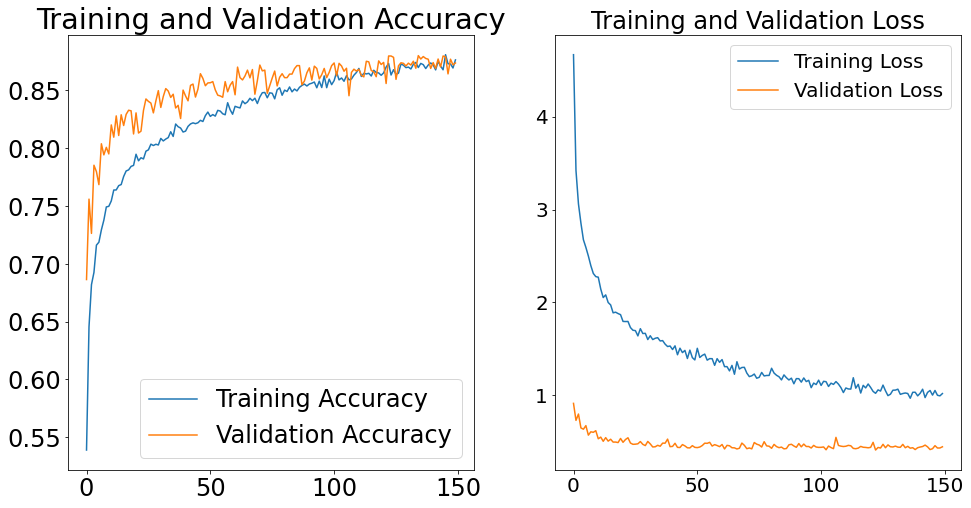

In [27]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.rcParams.update({'font.size': 20})

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.rcParams.update({'font.size': 20})
plt.show()



Found 6336 images belonging to 10 classes.

 Confusion Matrix 
[[ 728   39    1   10    2   22   14    1   93   47]
 [  23  532    4    5    2    1    7    3   33   29]
 [   1    3   50    2    0    0    0    1    1    4]
 [  15   18    8  142    3   10    3    2   19   41]
 [   2    4    0    0 1293    0    2    1    3    0]
 [  15    7    0    2    5  415    9    2   49    1]
 [   1    2    0    0    0    0   70    0    4    0]
 [   1    1    0    0    1    0    0  352    2    0]
 [  35    8    0    3    1    9    7    0  239   11]
 [  34   33    4   14    1    1    0    3   42 1728]] 

Classification Report
                        precision    recall  f1-score   support

           Al$_2$O$_3$       0.85      0.76      0.80       957
               CeO$_2$       0.82      0.83      0.83       639
           Co$_2$O$_3$       0.75      0.81      0.78        62
                   MgO       0.80      0.54      0.65       261
                   NPs       0.99      0.99      0.99      13

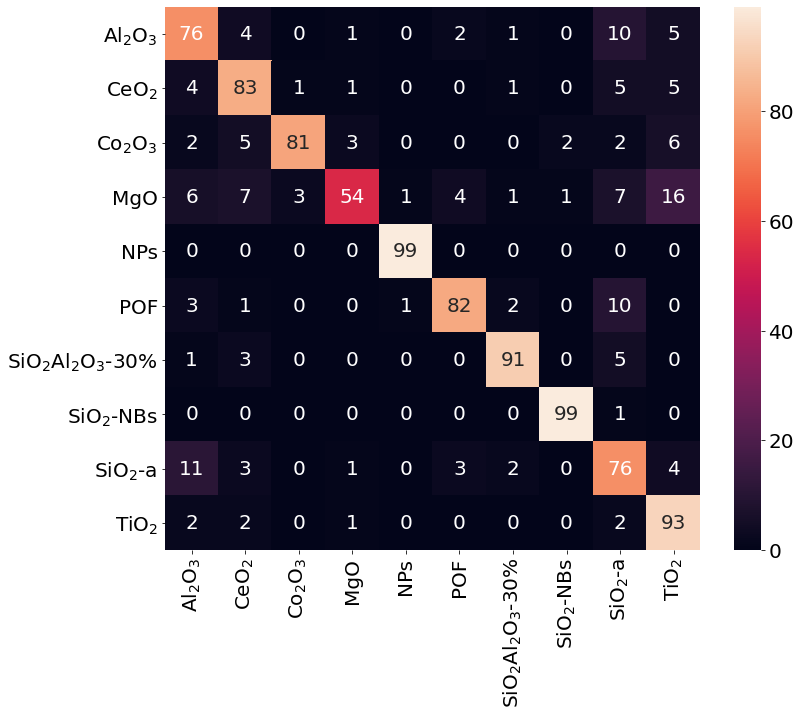

In [28]:
#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

#pull new validation data, that is unshuffled, for confusion matrix
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              shuffle = False)

target_names = ['Al$_2$O$_3$', 'CeO$_2$', 'Co$_2$O$_3$', 'MgO', 'NPs', 'POF', 'SiO$_2$Al$_2$O$_3$-30%', 'SiO$_2$-NBs', 'SiO$_2$-a', 'TiO$_2$']

Y_pred = model_aug.predict_generator(val_data_gen, 6336 // batch_size+1) #distribution between classes
y_pred = np.argmax(Y_pred, axis=1) #most likely class
print('\n', 'Confusion Matrix ')
conf_mat = confusion_matrix(val_data_gen.classes, y_pred)
print(conf_mat, '\n')
print('Classification Report')
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

#beautiful confusion matrix as percentages with sklearn
row_sums = np.sum(conf_mat, axis = 1, keepdims = True)
conf_mat = np.round(conf_mat / row_sums * 100, 0) #get rid of the decimal
df_cm = pd.DataFrame(conf_mat, index = [i for i in target_names],
                  columns = [i for i in target_names])
fig = plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True)
plt.rcParams.update({'font.size': 24})

#average the diagonals of the confusion matrix to get 'class-balanced accuracy'
final_acc = 0
for i in range(len(conf_mat)):
  final_acc += conf_mat[i,i]
final_acc /= 10
print('Class-balanced final accuracy is {} percent'.format(final_acc))